<div align='center' ><img src='https://raw.githubusercontent.com/davidrpugh/numerical-methods/master/images/sgpe-logo.jpg' width="1200" height="100"></div>
<div align='right'><img src='https://raw.githubusercontent.com/davidrpugh/numerical-methods/master/images/SIRElogolweb.jpg' width="1200" height="100"></div>

This notebook demonstrates the functionality of the `quantecon.models.solow` module. The code was developed with funding from the Scottish Graduate Programme in Economics (SGPE) and the Scottish Institute for Research in Economics (SIRE). The code has found widespread use in  my own research and teaching and it is my fervent hope that others will adapt and contribute to the development of these notebooks for use in their own research and teaching.



In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sympy as sym

from quantecon.models import solow

# 0. Motivation

The typical economics graduate student places great faith in the analytical mathematical tools that he or she was taught as an undergraduate. In particular this student is likely under the impression that virtually all economic models have closed-form solutions. At best the typical student believes that if he or she were to encounter an economic model without a closed-form solution, then simplifying assumptions could be made that would render the model analytically tractable without sacrificing important economic content. 

The typical economics student is, of course, wrong about general existence of closed-form solutions to economic models. In fact the opposite is true: most economic models, particular dynamic, non-linear models with meaningful constraints (i.e., most any *interesting* model) will fail to have an analytic solution. I the objective of this notebook is to demonstrate this fact and thereby motivate the use of numerical methods in economics more generally using the [Solow model of economic growth](http://faculty.smu.edu/tosang/pdf/Solow_1956.pdf). 

Economics graduate students are very familiar with the Solow growth model. For many students, the Solow model will have been one of the first macroeconomic models taught to them as undergraduates. Indeed, Greg Mankiw's [*Macroeconomics*](http://www.macmillanhighered.com/Catalog/product/macroeconomics-eighthedition-mankiw), the dominant macroeconomics textbook for first and second year undergraduates, devotes two full chapters to motivating and deriving the Solow model. The first few chapters of David Romer's [*Advanced Macroeconomics*](http://highered.mheducation.com/sites/0073511374/index.html), one of the most widely used final year undergraduate and first-year graduate macroeconomics textbook, are also devoted to the Solow growth model and its descendants.


## 0.1 The basic Solow growth model
The Solow model can be reduced down to a single non-linear differential equation and associated initial condition describing the time evolution of capital stock (per unit effective labor), $k(t)$.

$$ \dot{k}(t) = sf(k(t)) - (n + g + \delta)k(t),\ k(t) = k_0 \tag {0.1.1} $$

The parameter $0 < s < 1$ is the fraction of output invested and the parameters $n, g, \delta$ are the rates of population growth, technological progress, and depreciation of physical capital. The intensive form of the production function $f$ is assumed to be to be strictly concave with 

$$ f(0) = 0,\ lim_{k\rightarrow 0}\ f' = \infty,\ lim_{k\rightarrow \infty}\ f' = 0. \tag{0.1.2} $$ 

A common choice for the function $f$ which satisfies the above conditions is known as the Cobb-Douglas production function.

$$ f(k(t)) = k(t)^{\alpha} $$

Assuming a Cobb-Douglas functional form for $f$ also makes the model analytically tractable (and thus contributes to the typical economics student's belief that all such models "must" have an analytic solution). [Sato 1963](http://www.jstor.org/stable/2296026) showed that the solution to the model under the assumption of Cobb-Douglas production is

$$ k(t) = \Bigg[\bigg(\frac{s}{n+g+\delta}\bigg)\bigg(1 - e^{-(n+g+\delta)(1-\alpha)t}\bigg)+ k_0^{1-\alpha}e^{-(n+g+\delta)(1-\alpha)t}\Bigg]^{\frac{1}{1-\alpha}}. \tag{0.1.3} $$

A notable property of the Solow model with Cobb-Douglas production is that the model predicts that the shares of real income going to capital and labor should be constant. Denoting capital's share of income as $\alpha_K(k)$, the model predicts that 

$$ \alpha_K(k(t)) \equiv \frac{\partial \ln f(k(t))}{\partial \ln k(t)} = \alpha \tag{0.1.4} $$

Note that the prediction is that factor shares are constant along both the balanced growth path *and* during the disequilibrium transient (i.e., the period in which $k(t)$ is varying).  We can test this implication of the model using data from the newest version of the [Penn World Tables (PWT)](http://www.rug.nl/research/ggdc/data/penn-world-table). 

To access the PWT data set we will use the [pyPWT](https://github.com/davidrpugh/penn-world-tables) library. Unless you have run this notebook before, `pypwt` will likely need to be installed on your machine. The easiest way to install `pypwt` is to use `pip` from the command line...

```
$ pip install pypwt
```

...now that `pypwt` has been succesfully installed we are ready to import the library...

In [3]:
try:
    import pypwt
except ImportError:
    raise ImportError("Looks like you still need to install pypwt!")

...if the above did not raise an error, then congrats you have successfully installed `pypwt`! If you get an error, then check that you ran
```
$ pip install pypwt
```
from the command line (and that the installation returned with success!). Assuming success, now we are ready to load the PWT data!

In [4]:
pwt = pypwt.load_pwt_data()

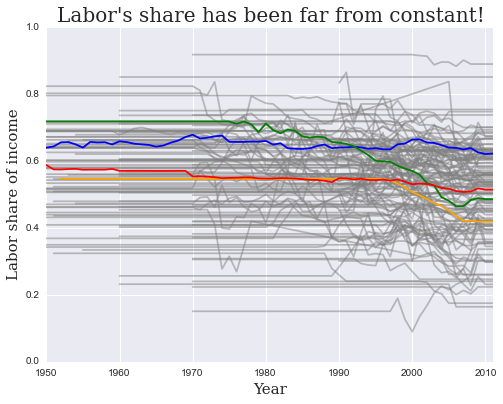

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for ctry in pwt.major_axis:
    tmp_data = pwt.major_xs(ctry)
    tmp_data.labsh.plot(color='gray', alpha=0.5)
    
# plot some specific countries
pwt.major_xs('USA').labsh.plot(color='blue', ax=ax, label='USA')
pwt.major_xs('IND').labsh.plot(color='green', ax=ax, label='IND')
pwt.major_xs('CHN').labsh.plot(color='orange', ax=ax, label='CHN')

# plot global average
avg_labor_share = pwt.labsh.mean(axis=0)
avg_labor_share.plot(color='r', ax=ax)

ax.set_title("Labor's share has been far from constant!",
             fontsize=20, family='serif')
ax.set_xlabel('Year', family='serif', fontsize=15)
ax.set_ylabel('Labor share of income', family='serif', fontsize=15)
ax.set_ylim(0, 1)

plt.show()

From the above figure it is clear that the prediction of constant factor shares is strongly at odds with the empirical data for most countries. Labor's share of real GDP has been declining, on average, for much of the post-war period. For many countries, such as India, China, and South Korea, the fall in labor's share has been dramatic. Note also that the observed trends in factor shares are inconsistent with an economy being on its long-run balanced growth path. 

## 0.2 A more general Solow growth model

While the data clearly reject the Solow model with Cobb-Douglas production, they are *not* inconsistent with the Solow model in general. A simple generalization of the Cobb-Douglas production function, known as the constant elasticity of substitution (CES) function:

$$ f(k(t)) = \bigg[\alpha k(t)^{\rho} + (1-\alpha)\bigg]^{\frac{1}{\rho}} $$

where $-\infty < \rho < 1$ is the elasticity of substitution between capital and effective labor in production is capable of generating the variable factor shares observed in the data. Note that 
   
$$ \lim_{\rho\rightarrow 0} f(k(t)) = k(t)^{\alpha} $$

and thus the CES production function nests the Cobb-Douglas functional form as a special case.

To see that the CES production function also generates variable factor shares note that 

$$ \alpha_K(k(t)) \equiv \frac{\partial \ln f(k(t))}{\partial \ln k(t)} = \frac{\alpha k(t)^{\rho}}{\alpha k(t)^{\rho} + (1 - \alpha)} $$

which varies with $k(t)$.

This seemingly simple generalization of the Cobb-Douglas production function, which is necessary in order for the Solow model generate variable factor share, an economically important feature of the post-war growth experience in most countries, renders the Solow model analytically intractable. To make progress solving a Solow growth model with CES production one needs to resort to computational methods.

# 1. Creating an instance of the `solow.Model` class

We begin by creating an instance of the `solow.Model` class in the IPython notebook. As always, it is a good idea to read the docstrings...

In [5]:
solow.Model?

 From the docsting we see that in order to create an instance of the model we need to specify two primitives: the extensive production function, $F$, and a dictionary of model parameters.

In [6]:
# define model variables
A, K, L = sym.symbols('A, K, L')

# define production parameters
alpha, sigma = sym.symbols('alpha, sigma')

# specify some production function
rho = (sigma - 1) / sigma
ces_output = (alpha * K**rho + (1 - alpha) * (A * L)**rho)**(1 / rho)

In [7]:
# define model parameters
ces_params = {'A0': 1.0, 'L0': 1.0, 'g': 0.02, 'n': 0.03, 's': 0.15,
              'delta': 0.05, 'alpha': 0.33, 'sigma': 0.95}

# create an instance of the solow.Model class
ces_model = solow.CESModel(params=ces_params)

More details on on how to create instances of the `solow.Model` class can be found in the **Getting started** notebook in the [solowPy](https://github.com/davidrpugh/solowPy) repository.

# 2. Finding the steady state

Traditionally, most analysis of the Solow model focuses almost excusively on the long run steady state of the model. Recall that the steady state of the Solow model is the value of capital stock (per unit effective labor) that solves

$$ 0 = sf(k^*) - (g + n + \delta)k^*. \tag{2.0.1} $$

In words: in the long-run, capital stock (per unit effective labor) converges to the value that balances actual investment, $sf(k)$, with effective depreciation, $(g + n + \delta)$. Given the assumption made about the aggregate production technology, $F$, and its intensive form, $f$, there is always a unique value $k^* >0$ satisfying equation 2.0.1.

Although it is trivial to derive an analytic expression for the long-run equilibrium of the Solow model for most intensive production functions, the Solow model serves as a good illustrative case for various numerical methods for solving non-linear equations.

The `solow.Model.find_steady_state` method provides a simple interface to the various 1D root finding routines available in `scipy.optimize` and uses them to solve the non-linear equation 2.0.1. To see the list of currently supported methods, check out the docstring for the `Model.find_steady_state` method...

In [8]:
solow.Model.find_steady_state?

In [9]:
k_star, result = ces_model.find_steady_state(1e-6, 1e6, method='bisect', full_output=True)

In [10]:
print("The steady-state value is {}".format(k_star))
print("Did the bisection algorithm coverge? {}".format(result.converged))

The steady-state value is 1.82583173149
Did the bisection algorithm coverge? True


More details on on how to the various methods of the `solow.Model` class for finding the model's steady state can be found in the accompanying **Finding the steady state** notebook in the [solowPy](https://github.com/davidrpugh/solowPy) repository.

# 3. Graphical analysis using Matplotlib and IPython widgets

Graphical analysis is an important pedagogic and research technique for understanding the behavior of the Solow (or really any!) model and as such the `solow.Model` class has a number of useful, built-in plotting methods.

## Static example: the classic Solow diagram

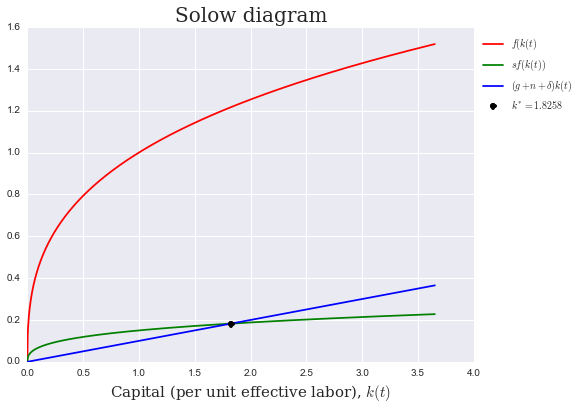

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ces_model.plot_solow_diagram(ax)
fig.show()

## Interactive example: the classic Solow diagram

In [12]:
from IPython.html.widgets import fixed, interact, FloatSliderWidget

<function __main__.interactive_solow_diagram>

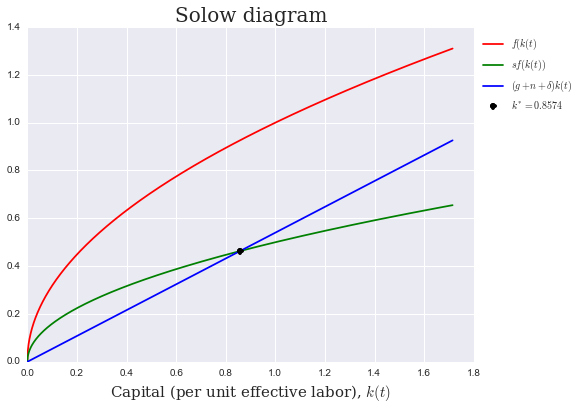

In [13]:
# wrap the static plotting code in a function
def interactive_solow_diagram(model, **params):
    """Interactive widget for the Solow diagram."""
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    model.plot_solow_diagram(ax, Nk=1000, **params)
    
# define some widgets for the various parameters
eps = 1e-2
technology_progress_widget = FloatSliderWidget(min=-0.05, max=0.05, step=eps, value=0.02)
population_growth_widget = FloatSliderWidget(min=-0.05, max=0.05, step=eps, value=0.02)
savings_widget = FloatSliderWidget(min=eps, max=1-eps, step=eps, value=0.5)
output_elasticity_widget = FloatSliderWidget(min=eps, max=1.0, step=eps, value=0.5)
depreciation_widget = FloatSliderWidget(min=eps, max=1-eps, step=eps, value=0.5)
elasticity_substitution_widget = FloatSliderWidget(min=eps, max=10.0, step=0.01, value=1.0+eps)

# create the widget!
interact(interactive_solow_diagram, 
         model=fixed(ces_model),
         g=technology_progress_widget,
         n=population_growth_widget,
         s=savings_widget, 
         alpha=output_elasticity_widget,
         delta=depreciation_widget,
         sigma=elasticity_substitution_widget,
         )

There are number of additional plotting methods available (all of which can be turned into interactive plots using IPython widgets). See the **Graphical analysis** notebook in the [solowPy](https://github.com/davidrpugh/solowPy) repository.

# 4. Solving the Solow model

Solving the Solow model requires efficiently and accurately approximating the solution to a non-linear ordinary differential equation (ODE) with a given initial condition (i.e., an non-linear initial value problem). 

## 4.1 Solow model as an initial value problem

The Solow model with can be formulated as an initial value problem (IVP) as follows.

$$ \dot{k}(t) = sf(k(t)) - (g + n + \delta)k(t),\ t\ge t_0,\ k(t_0) = k_0 \tag{4.1.0} $$

The `quantecon` library has its own module `quantecon.ivp` for solving initial value problems of this form using [finite difference methods](http://en.wikipedia.org/wiki/Finite_difference_method). Upon creation of our instance of the `solow.Model` class, an instance of the `quantecon.ivp.IVP` class was created and stored as an attribute of our model...

In [14]:
ces_model.ivp?

...meaning that we can solve this initial value problem by applying the `solve` method of the `ivp` attribute!

In [15]:
ces_model.ivp.solve?

In [16]:
# need to specify some initial conditions
t0, k0 = 0.0, 0.5
numeric_soln = ces_model.ivp.solve(t0, k0, T=100, integrator='dopri5')

We can plot the finite-difference approximation of the solution as follows...

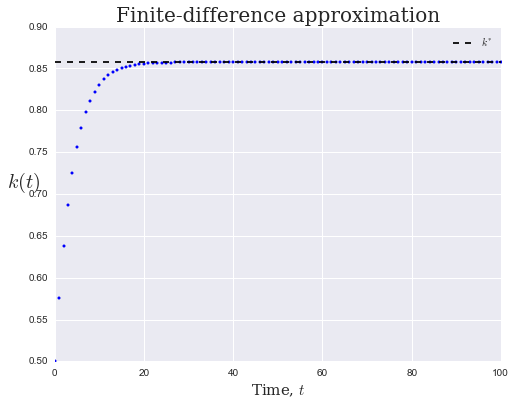

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# plot the finite-difference-approximation
ax.plot(numeric_soln[:,0], numeric_soln[:,1], 'bo', markersize=3.0)

# equilibrium value of capital stock (per unit effective labor)
k_star = ces_model.steady_state
ax.axhline(k_star, linestyle='dashed', color='k', label='$k^*$')

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=15, family='serif')
ax.set_ylabel('$k(t)$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('Finite-difference approximation',
             fontsize=20, family='serif')
ax.legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
ax.grid('on')

plt.show()

Finite-difference methods only return a discrete approximation to the continuous function $k(t)$. To get a continouous approximation of the solution we can combined finite-difference methods with [B-spline interpolation](http://en.wikipedia.org/wiki/B-spline) using the `interpolate` method of the `ivp` attribute.

In [18]:
ces_model.ivp.interpolate?

In [19]:
# interpolate!
ti = np.linspace(0, 100, 1000)
interpolated_soln = ces_model.ivp.interpolate(numeric_soln, ti, k=3)

We can graphically compare the discrete, finite-difference approximation with the continuous, B-spline approximation as follows.

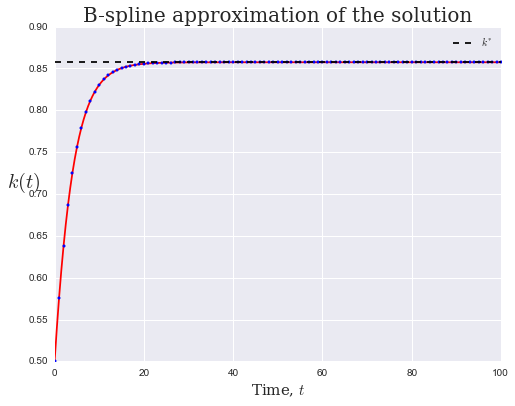

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# plot the interpolated and finite difference approximations
ax.plot(ti, interpolated_soln[:,1], 'r-')
ax.plot(numeric_soln[:,0], numeric_soln[:,1], 'bo', markersize=3.0)

# equilibrium value of capital stock (per unit effective labor)
k_star = ces_model.steady_state
ax.axhline(k_star, linestyle='dashed', color='k', label='$k^*$')

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=15, family='serif')
ax.set_ylabel('$k(t)$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('B-spline approximation of the solution',
             fontsize=20, family='serif')
ax.legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))

plt.show()

## Accuracy of our numerical methods

When doing numerical work it is important to understand the accuracy of the methods that you are using to approximate the solution to your model. Typically one assesses the accuracy of a solution method by computing and evaluatin some residual function:

$$ R(k; \theta) = sf(\hat{k}(\theta)) - (g + n + \delta)\hat{k}(\theta) - \dot{\hat{k}}(\theta) $$

where $\hat{k}(\theta)$ is out computed solution to the original differential equation.  We can assess the accuracy of our finite-difference methods by plotting the residual function for our approximate solution using the `compute_residual` method of the `ivp` attribute.

In [21]:
# compute the residual...
ti = np.linspace(0, 100, 1000)
residual = ces_model.ivp.compute_residual(numeric_soln, ti, k=3)

We can then plot the residual as follows. Our approximation is accurate so long as the residual is everywhere "close" to zero.

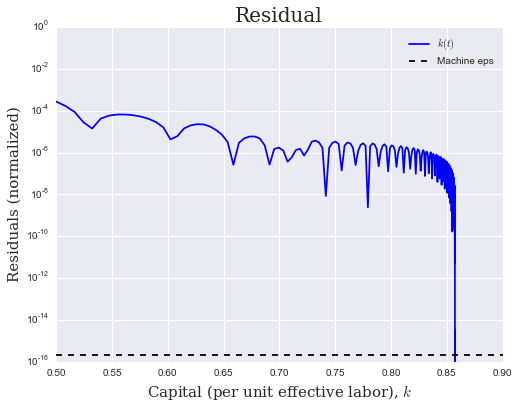

In [22]:
# extract the raw residuals
capital_residual = residual[:, 1]

# typically, normalize residual by the level of the variable
norm_capital_residual = np.abs(capital_residual) / interpolated_soln[:,1]

# create the plot
fig = plt.figure(figsize=(8, 6))
plt.plot(interpolated_soln[:,1], norm_capital_residual, 'b-', label='$k(t)$')
plt.axhline(np.finfo('float').eps, linestyle='dashed', color='k', label='Machine eps')
plt.xlabel('Capital (per unit effective labor), $k$', fontsize=15, family='serif')
plt.ylim(1e-16, 1)
plt.ylabel('Residuals (normalized)', fontsize=15, family='serif')
plt.yscale('log')
plt.title('Residual', fontsize=20, family='serif')
plt.legend(loc=0, frameon=False, bbox_to_anchor=(1.0,1.0))
plt.show()

For more details behind the numerical methods used in this section see the the **Solving the Solow model** notebook in the [solowPy](https://github.com/davidrpugh/solowPy) repository.

# 5. Impulse response functions

Impulse response functions (IRFs) are a standard tool for analyzing the short run dynamics of dynamic macroeconomic models, such as the Solow growth model, in response to an exogenous shock. The `solow.impulse_response.ImpulseResponse` class has several attributes and methods for generating and analyzing impulse response functions. 

### Example: Impact of a change in the savings rate
One can analyze the impact of a doubling of the savings rate on model variables as follows.

In [23]:
# 50% increase in the current savings rate...
ces_model.irf.impulse = {'s': 1.5 * ces_model.params['s']}

# in efficiency units...
ces_model.irf.kind = 'efficiency_units'

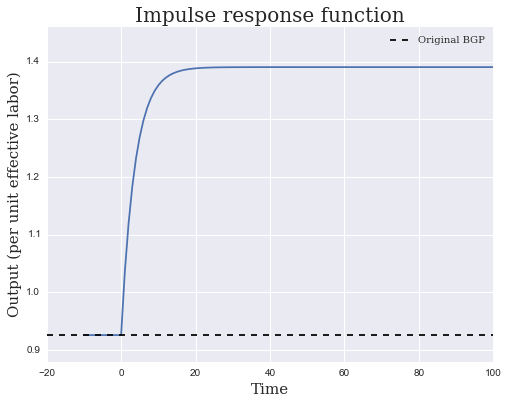

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ces_model.irf.plot_impulse_response(ax, variable='output')
plt.show()

### Example: Interactive impulse reponse functions
Using IPython widgets makes it extremely easy to analyze the various impulse response functions.

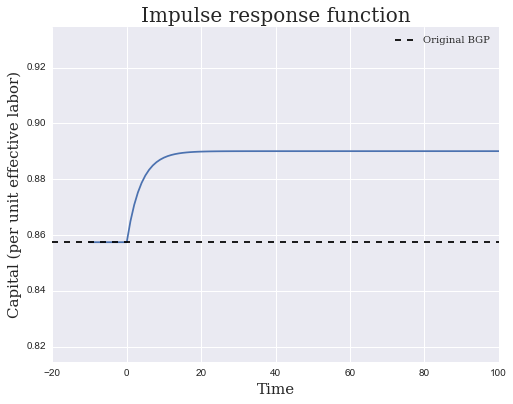

In [25]:
def interactive_impulse_response(model, shock, param, variable, kind, log_scale):
    """Interactive impulse response plotting tool."""    
    # specify the impulse response
    model.irf.impulse = {param: shock * model.params[param]}
    model.irf.kind = kind
    
    # create the plot
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    model.irf.plot_impulse_response(ax, variable=variable, log=log_scale)
    

irf_widget = interact(interactive_impulse_response, 
                      model=fixed(ces_model),
                      shock = FloatSliderWidget(min=0.1, max=5.0, step=0.1, value=0.5),
                      param = ['g', 'n', 's', 'alpha', 'delta' , 'sigma'],
                      variable=['capital', 'output', 'consumption', 'investment'],
                      kind=['efficiency_units', 'per_capita', 'levels'],
                      log_scale=False,
                      )

For more details and examples see the accompanying **Impulse response function** notebook in the [solowPy](https://github.com/davidrpugh/solowPy) repository.

# 6. The Solow model, declining labor's share, and secular stagnation

Recently there has been much discussion about the reasons for the decline in labor's share of income (see [Elsby (2013)](http://www.brookings.edu/~/media/Projects/BPEA/Fall%202013/2013b_elsby_labor_share.pdf) for an analysis using U.S. data); as well as much debate about whether or not developed economes are experiencing some sort of [secular stagnation](http://www.economist.com/blogs/buttonwood/2014/11/secular-stagnation) more generally.

Let's see if the Solow model can match the following stylized facts:

1. A decline in labor's share of output/income (note this implies rising capital's share)
2. A slow-down in the growth rate of per capita output/income.


<function __main__.awesome_interactive_plot>

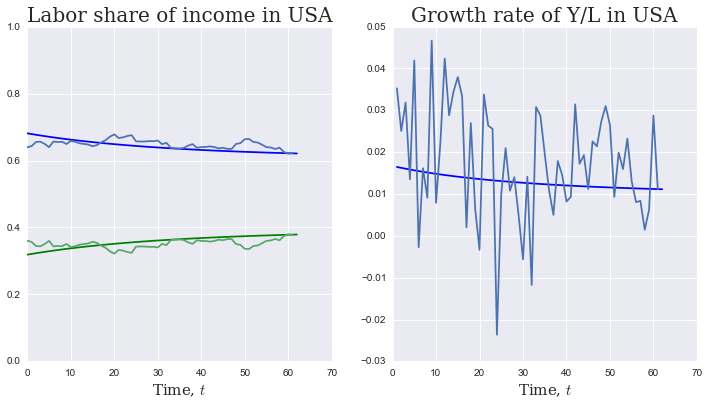

In [27]:
def awesome_interactive_plot(model, iso3_code, **params):
    """Interactive widget for the my awesome plot."""
    
    # extract the relevant data
    tmp_data = pwt.major_xs(iso3_code)
    actual_labor_share = tmp_data.labsh.values
    actual_capital_share = 1 - tmp_data.labsh
    
    output = tmp_data.rgdpna
    capital = tmp_data.rkna
    labor = tmp_data.emp
    
    # need to update params
    model.params.update(params)
    
    # get new initial condition
    implied_technology = model.evaluate_solow_residual(output, capital, labor)
    k0 = tmp_data.rkna[0] / (implied_technology[0] * labor[0])
    
    # finite difference approximation
    T = actual_labor_share.size
    soln = model.ivp.solve(t0, k0, T=T, integrator='dopri5')
    
    # get predicted labor share
    predicted_capital_share = model.evaluate_output_elasticity(soln[:,1])
    predicted_labor_share = 1 - predicted_capital_share
        
    # get predicted output per unit labor
    predicted_intensive_output = model.evaluate_intensive_output(soln[:,1])
    technology = implied_technology[0] * np.exp(ces_model.params['g'] * soln[:,0])
    predicted_output_per_unit_labor = predicted_intensive_output * technology

    # make the plots!
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    axes[0].plot(soln[:,0], predicted_labor_share, 'b')
    axes[0].plot(soln[:,0], predicted_capital_share, 'g')
    axes[0].plot(actual_labor_share)
    axes[0].plot(actual_capital_share)    
    axes[0].set_xlabel('Time, $t$', fontsize=15, family='serif')
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Labor share of income in {}'.format(iso3_code),
                      fontsize=20, family='serif')
    axes[0].legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
    
    axes[1].set_xlabel('Time, $t$', fontsize=15, family='serif')
    axes[1].set_title('Growth rate of Y/L in {}'.format(iso3_code),
                      fontsize=20, family='serif')
    axes[1].legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
    axes[1].plot(soln[1:,0], np.diff(np.log(predicted_output_per_unit_labor)),
                 'b', markersize=3.0)
    axes[1].plot(np.log(output / labor).diff().values)

    
# define some widgets for the various parameters
technology_progress_widget = FloatSliderWidget(min=-0.05, max=0.05, step=5e-3, value=0.01)
population_growth_widget = FloatSliderWidget(min=-0.05, max=0.05, step=5e-3, value=0.01)
savings_widget = FloatSliderWidget(min=eps, max=1-eps, step=5e-3, value=0.2)
output_elasticity_widget = FloatSliderWidget(min=eps, max=1.0, step=5e-3, value=0.175)
depreciation_widget = FloatSliderWidget(min=eps, max=1-eps, step=5e-3, value=0.02)
elasticity_substitution_widget = FloatSliderWidget(min=eps, max=10.0, step=1e-2, value=2.0+eps)

# create the widget!
interact(awesome_interactive_plot, 
         model=fixed(ces_model),
         iso3_code='USA',
         g=technology_progress_widget,
         n=population_growth_widget,
         s=savings_widget, 
         alpha=output_elasticity_widget,
         delta=depreciation_widget,
         sigma=elasticity_substitution_widget,
         )